Acurácia com kernel linear: 0.98 Penalidade: 1.0

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       0.98      0.98      0.98        50
           2       0.98      1.00      0.99        47
           3       1.00      0.96      0.98        54
           4       0.98      0.98      0.98        60
           5       0.97      0.97      0.97        66
           6       1.00      1.00      1.00        53
           7       0.96      0.98      0.97        55
           8       0.95      0.98      0.97        43
           9       0.97      0.95      0.96        59

    accuracy                           0.98       540
   macro avg       0.98      0.98      0.98       540
weighted avg       0.98      0.98      0.98       540

Acurácia com kernel linear: 0.98 Penalidade: 2.0

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1

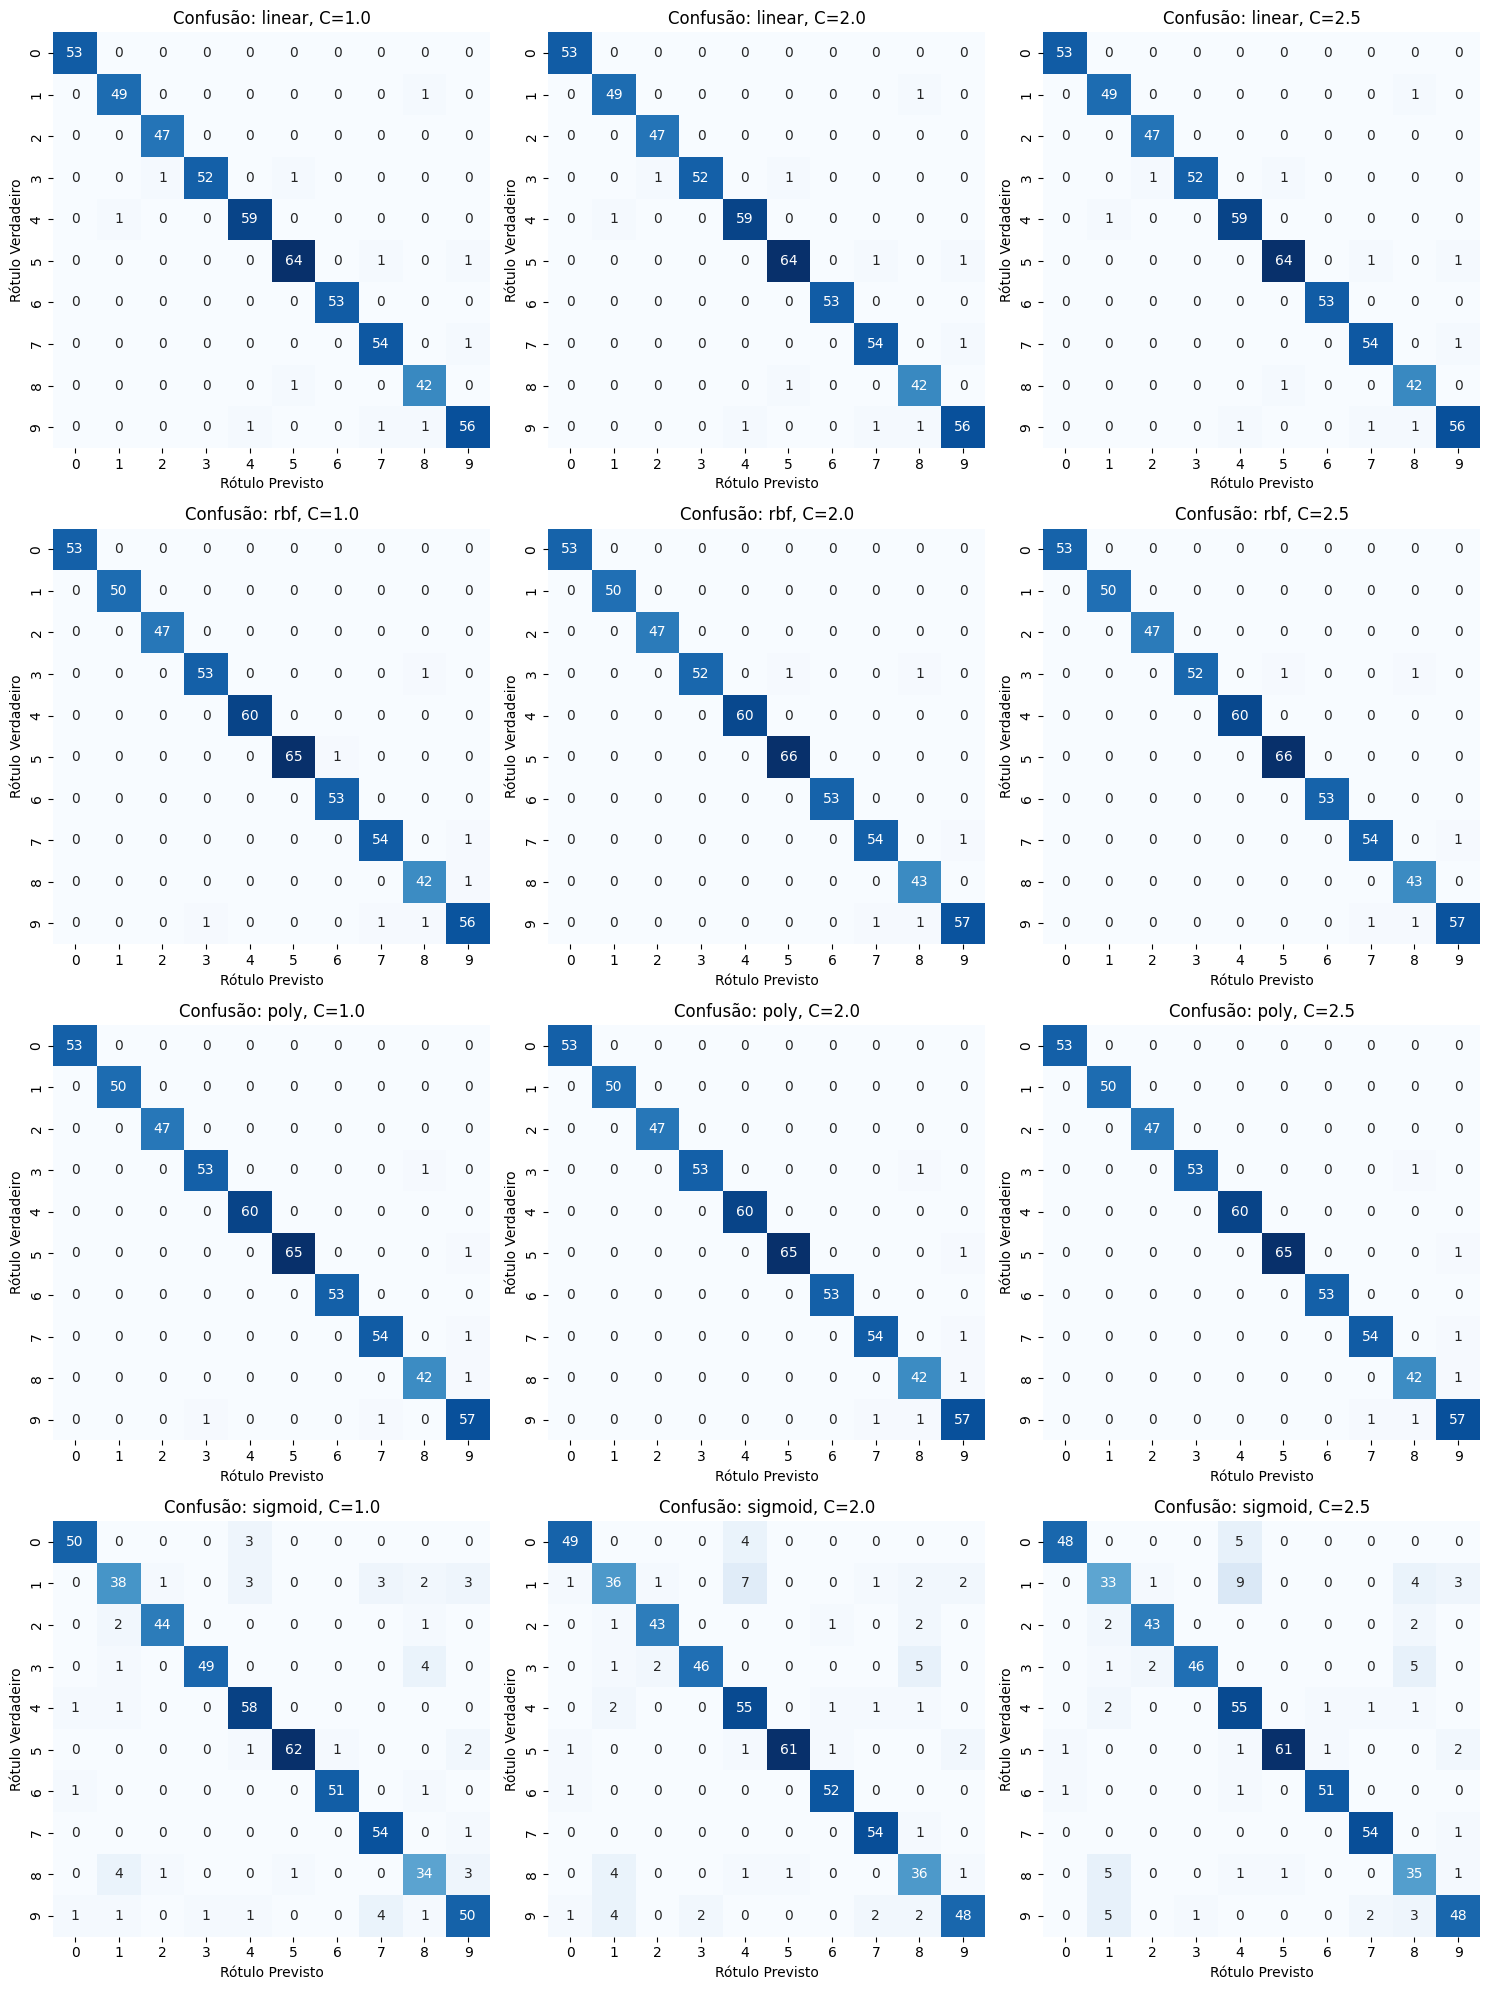

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Carregar o dataset digits
digits = datasets.load_digits()
X = digits.data
y = digits.target

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

kernels = ['linear', 'rbf', 'poly', 'sigmoid']
C_values = [1.0, 2.0, 2.5]
num_plots = len(kernels) * len(C_values)
rows = (num_plots + 2) // 3  # Calcula o número de linhas necessárias para agrupar de 3 em 3

fig, axes = plt.subplots(rows, min(num_plots, 3), figsize=(15, 5 * rows))
axes = axes.flatten()  # Para facilitar a indexação dos subplots

plot_index = 0
for kernel in kernels:
    for C in C_values:
        clf = svm.SVC(kernel=kernel, gamma='scale', C=C) #scale: é uma boa pratica pois absorve o length total de features, C: controla a penalidade por erros de classificação. comporta-se como um parâmetro de regularização na SVM
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        ax = axes[plot_index]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=digits.target_names,
                    yticklabels=digits.target_names, ax=ax, cbar=False)
        ax.set_xlabel('Rótulo Previsto')
        ax.set_ylabel('Rótulo Verdadeiro')
        ax.set_title(f'Confusão: {kernel}, C={C}')
        plot_index += 1

        accuracy = accuracy_score(y_test, y_pred)    
        print(f"Acurácia com kernel {kernel}: {accuracy:.2f} Penalidade: {C}")
        print("\nRelatório de Classificação:")
        print(classification_report(y_test, y_pred))

# Remover subplots extras se o número de plots não for um múltiplo de 3
if num_plots < len(axes):
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.multiclass import OneVsRestClassifier

# Carregar o dataset digits
digits = datasets.load_digits()
X = digits.data
y = digits.target

# Separar dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Definir os classificadores a serem treinados e avaliados
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression (OVR)': OneVsRestClassifier(LogisticRegression(random_state=42, solver='liblinear')),
    'SVM (RBF)': SVC(kernel='rbf', gamma='scale', C=2.0, random_state=42)
}

# Métricas a serem avaliadas
metrics = {
    'Acurácia': accuracy_score,
    'Acurácia Balanceada': balanced_accuracy_score,
    'Precisão (Macro)': lambda y_true, y_pred: precision_score(y_true, y_pred, average='macro'),
    'Recall (Macro)': lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro'),
    'F1-Score (Macro)': lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro')
}

print("Resultados da Validação (Cross-Validation):\n")

results_validation = {}
n_splits = 5  # Número de folds para a validação cruzada
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for name, clf in classifiers.items():
    print(f"--- {name} ---")
    results_validation[name] = {}
    for metric_name, metric_func in metrics.items():
        scores = cross_val_score(clf, X_train, y_train, cv=skf, scoring='accuracy') # Usando acurácia para cross-validation
        results_validation[name][metric_name] = np.mean(scores)
        print(f"{metric_name}: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")
    print("-" * (len(name) + 7))

print("\nResultados no Conjunto de Teste:\n")

results_test = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    results_test[name] = {}
    print(f"--- {name} ---")
    print(f"Relatório de Classificação:\n{classification_report(y_test, y_pred)}")
    for metric_name, metric_func in metrics.items():
        score = metric_func(y_test, y_pred)
        results_test[name][metric_name] = score
        print(f"{metric_name}: {score:.4f}")
    print("-" * (len(name) + 7))

print("\nComparação dos Melhores Classificadores com o SVM no Conjunto de Teste:\n")

best_classifier_name = None
best_accuracy = 0.0

for name, results in results_validation.items():
    if results['Acurácia'] > best_accuracy:
        best_accuracy = results['Acurácia']
        best_classifier_name = name

print(f"Melhor classificador na validação cruzada (baseado na acurácia): {best_classifier_name} com acurácia de {best_accuracy:.4f}\n")

print("Resultados no Conjunto de Teste:")
print(f"--- {best_classifier_name} ---")
for metric_name, score in results_test[best_classifier_name].items():
    print(f"{metric_name}: {score:.4f}")
print("-" * (len(best_classifier_name) + 7))

print(f"\n--- SVM (RBF) ---")
for metric_name, score in results_test['SVM (RBF)'].items():
    print(f"{metric_name}: {score:.4f}")
print("-" * 11)

Resultados da Validação (Cross-Validation):

--- Random Forest ---
Acurácia: 0.9706 (+/- 0.0074)
Acurácia Balanceada: 0.9706 (+/- 0.0074)
Precisão (Macro): 0.9706 (+/- 0.0074)
Recall (Macro): 0.9706 (+/- 0.0074)
F1-Score (Macro): 0.9706 (+/- 0.0074)
--------------------
--- Logistic Regression (OVR) ---
Acurácia: 0.9499 (+/- 0.0109)
Acurácia Balanceada: 0.9499 (+/- 0.0109)
Precisão (Macro): 0.9499 (+/- 0.0109)
Recall (Macro): 0.9499 (+/- 0.0109)
F1-Score (Macro): 0.9499 (+/- 0.0109)
--------------------------------
--- SVM (RBF) ---
Acurácia: 0.9904 (+/- 0.0032)
Acurácia Balanceada: 0.9904 (+/- 0.0032)
Precisão (Macro): 0.9904 (+/- 0.0032)
Recall (Macro): 0.9904 (+/- 0.0032)
F1-Score (Macro): 0.9904 (+/- 0.0032)
----------------

Resultados no Conjunto de Teste:

--- Random Forest ---
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        54
           1       0.93      1.00      0.96        55
           2 

Análise:

Kernels

RBF parece consistentemente fornecer o melhor desempenho para os valores de C testados neste conjunto de dados.

Poly também alcança um bom desempenho, especialmente com valores de C mais altos, aproximando-se do RBF.

Linear apresenta um desempenho razoável, mas inferior aos kernels não lineares para este problema.

Sigmoid demonstra o desempenho mais fraco entre os kernels acima.

Penalidade

Existiu um ponto em que aumentar o valor de 2.0 para 2.5, o valor de C trouxe um ponto de saturação para o modelo, não houve melhora significativa em treinamento e também a capacidade de generalização não apresentou melhora significativa que valesse a pena o trade off com os custos de uma margem menor, uma fronteira de decisão mais complexa e um maior risco de overfitting.

Modelos

As matrizes de confusão sugererem que o SVM com kernel RBF e valores de C mais altos apresentava um desempenho superior, o que é fortemente corroborado pelos resultados quantitativos da validação cruzada. A acurácia de 99.04% na validação indica que o modelo RBF do SVM é altamente eficaz na classificação deste conjunto de dados.

O Random Forest também mostrou um desempenho notável (97.06% de acurácia), ficando em segundo lugar nos resultados da validação cruzada. A Regressão Logística (OVR) apresentou o desempenho mais baixo entre os três, embora ainda com uma acurácia respeitável de 94.99%.

Conjunto de Teste

Ao comparar os resultados no conjunto de teste, fica claro que o SVM com kernel RBF supera significativamente os outros dois classificadores em todas as métricas avaliadas. Sua acurácia de 99.07% indica uma capacidade notável de generalização para dados não vistos.

O Random Forest também apresenta um desempenho muito bom, com uma acurácia de 96.67%, sendo o segundo melhor classificador neste experimento. Ele demonstra um bom equilíbrio entre precisão e recall para a maioria das classes.

A Regressão Logística (OVR), embora ainda apresente um desempenho razoável com uma acurácia de 95.74%, fica ligeiramente atrás do Random Forest e significativamente atrás do SVM (RBF).
